In [1]:
run_gridsearch = False
skip_best_model_train = True
hyperparam_csv_file = "calpella_mts_hyperparams.csv"

In [2]:
import sys
import os
import itertools
current_dir = os.getcwd()
print(current_dir)

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all


In [3]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-LSTMs')
sys.path.insert(0, library_path)
print(sys.path)

['../../../../UCB-USACE-LSTMs', '/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all', '/Users/canruso/Desktop', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python310.zip', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/lib-dynload', '', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/setuptools/_vendor']


In [4]:
from pathlib import Path
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (combinedPlot, fancyCombinedPlot, combinedPlotFromDf, fancyCombinedPlotFromDf)

In [5]:
# Dynamically find the repo root from the current working directory
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-LSTMs')[0] + 'UCB-USACE-LSTMs'

# Construct the target path
target_path = os.path.join(library_path, 'UCB_training', 'models', 'calpella_all')

# Verify if the directory exists before changing
if os.path.exists(target_path):
    os.chdir(target_path)
    print("Current Working Directory:", os.getcwd())
    print("Train Basin File Exists:", os.path.exists("calpella")) 
else:
    print(f"Error: The target path '{target_path}' does not exist.")

Current Working Directory: /Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all
Train Basin File Exists: True


In [6]:
path_to_csv = Path(library_path +'/russian_river_data')
path_to_yaml = Path("calpella_mtslstm.yaml")
path_to_physics_data_1D = Path(library_path + "/russian_river_data/Calpella_daily_mts_shift.csv")
path_to_physics_data_1H = Path(library_path + "/russian_river_data/Calpella_hourly_mts.csv")

In [7]:
features_with_physics = {
    "1D": [
        "daily_EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
        "daily_EF RUSSIAN 20 PRECIP-INC SCREENED",
        "daily_POTTER VALLEY CA FLOW USGS_ADJUSTED",
        "daily_UKIAH CA HUMIDITY USAF-NOAA",
        "daily_UKIAH CA SOLAR RADIATION USAF-NOAA",
        "daily_UKIAH CA TEMPERATURE USAF-NOAA",
        "daily_UKIAH CA WINDSPEED USAF-NOAA",
        # Physics columns (daily)
        "daily_Capella Gage FLOW",
        "daily_EF Russian 20 ET-POTENTIAL",
        "daily_EF Russian 20 FLOW",
        "daily_EF Russian 20 FLOW-BASE",
        "daily_EF Russian 20 INFILTRATION",
        "daily_EF Russian 20 PERC-SOIL",
        "daily_EF Russian 20 SATURATION FRACTION"
    ],
    "1H": [
        "hourly_EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
        "hourly_EF RUSSIAN 20 PRECIP-INC SCREENED",
        "hourly_POTTER VALLEY CA FLOW USGS_ADJUSTED",
        "hourly_UKIAH CA HUMIDITY USAF-NOAA",
        "hourly_UKIAH CA SOLAR RADIATION USAF-NOAA",
        "hourly_UKIAH CA TEMPERATURE USAF-NOAA",
        "hourly_UKIAH CA WINDSPEED USAF-NOAA",
        # Physics columns (hourly)
        "hourly_Capella Gage FLOW",
        "hourly_EF Russian 20 ET-POTENTIAL",
        "hourly_EF Russian 20 FLOW",
        "hourly_EF Russian 20 FLOW-BASE",
        "hourly_EF Russian 20 INFILTRATION",
        "hourly_EF Russian 20 PERC-SOIL",
        "hourly_EF Russian 20 SATURATION FRACTION"
    ]
}

In [8]:
hyperparam_space = {
    "hidden_size": [64, 128, 256],
    "seq_length_1D": [90, 120],
    "seq_length_1H": [168, 336],
    "num_layers": [1],
    "epochs": [16,32]
}

fixed_dropout = 0.4
no_physics_results = []
physics_results = []

In [9]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seqD, seqH, nl, ep) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length_1D"],
            hyperparam_space["seq_length_1H"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"]
    ):

        hp = {
            "hidden_size": hs,
            "seq_length": {"1D": seqD, "1H": seqH},
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout
        }

        print(f"\nNoPhysics MTS: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=True,  
            extend_train_period=False,
            gpu=-1,
            is_mts=True,
            is_mts_data = True
        )
        trainer.train()
        csv_1d, metrics_1d = trainer.results(period="validation", mts_trk="1D")
        csv_1h, metrics_1h = trainer.results(period="validation", mts_trk="1H")

        row_data = {
            "hidden_size": hs,
            "seq_length_1D": seqD,
            "seq_length_1H": seqH,
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
            "NSE_1D": metrics_1d.get("NSE", 0),
            "NSE_1H": metrics_1h.get("NSE", 0)
        }
        no_physics_results.append(row_data)

    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE_1D", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping grid search!")

Skipping grid search!


In [10]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seqD, seqH, nl, ep) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length_1D"],
            hyperparam_space["seq_length_1H"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"]):

        hp = {
            "hidden_size": hs,
            "seq_length": {"1D": seqD, "1H": seqH},
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout
        }

        print(f"\nPhysics MTS: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file="_",
            hourly=True,
            extend_train_period=False,
            gpu=-1,
            is_mts=True,
            is_mts_data = True,
            basin="Calpella"
        )
        trainer.train()
        csv_1d, metrics_1d = trainer.results(period="validation", mts_trk="1D")
        csv_1h, metrics_1h = trainer.results(period="validation", mts_trk="1H")

        row_data = {
            "hidden_size": hs,
            "seq_length_1D": seqD,
            "seq_length_1H": seqH,
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
            "NSE_1D": metrics_1d.get("NSE", 0),
            "NSE_1H": metrics_1h.get("NSE", 0)
        }
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE_1D", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    best_params_df.to_csv(hyperparam_csv_file, index=False)
else:
    print("Skipping grid search!")

Skipping grid search!


In [11]:
if run_gridsearch:
    print(df_no_physics.iloc[0:4])
    df_no_physics.to_csv("calpella_mts_no_physics_gridsearch.csv", index=False)

In [12]:
if run_gridsearch:
    print(df_physics.iloc[0:4])
    df_physics.to_csv("calpella_mts_physics_gridsearch.csv", index=False)

In [13]:
if os.path.exists(hyperparam_csv_file):
    best_params_df = pd.read_csv(hyperparam_csv_file)
    best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
    best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()

    best_no_physics_params = {
        "epochs": int(best_no_phys["epochs"]),
        "hidden_size": int(best_no_phys["hidden_size"]),
        "seq_length": {
            "1D": int(best_no_phys["seq_length_1D"]),
            "1H": int(best_no_phys["seq_length_1H"])
        },
        "num_layers": int(best_no_phys["num_layers"]),
        "output_dropout": float(best_no_phys["output_dropout"])
    }

    best_physics_params = {
        "epochs": int(best_phys["epochs"]),
        "hidden_size": int(best_phys["hidden_size"]),
        "seq_length": {
            "1D": int(best_phys["seq_length_1D"]),
            "1H": int(best_phys["seq_length_1H"])
        },
        "num_layers": int(best_phys["num_layers"]),
        "output_dropout": float(best_phys["output_dropout"])
    }
    print("Loaded best hyperparams from CSV:")
    print("Best NO-PHYS:", best_no_physics_params)
    print("Best PHYS:", best_physics_params)
else:
    print(f"Error: {hyperparam_csv_file} not found. Did you run gridsearch?")

Loaded best hyperparams from CSV:
Best NO-PHYS: {'epochs': 16, 'hidden_size': 64, 'seq_length': {'1D': 90, '1H': 336}, 'num_layers': 1, 'output_dropout': 0.4}
Best PHYS: {'epochs': 16, 'hidden_size': 64, 'seq_length': {'1D': 90, '1H': 168}, 'num_layers': 1, 'output_dropout': 0.4}


In [14]:
if not skip_best_model_train:
    noPhysValTrainer = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=True,
        extend_train_period=False,
        gpu=-1,
        is_mts=True,
        is_mts_data = True
    )
    noPhysValTrainer.train()
    noPhys_val_csv_1D, noPhys_val_metrics_1D = noPhysValTrainer.results(period="validation", mts_trk="1D")
    noPhys_val_csv_1H, noPhys_val_metrics_1H = noPhysValTrainer.results(period="validation", mts_trk="1H")
    print("NO-PHYS VAL 1D => NSE =", noPhys_val_metrics_1D.get("NSE", None))
    print("NO-PHYS VAL 1H => NSE =", noPhys_val_metrics_1H.get("NSE", None))

In [15]:
if not skip_best_model_train:
    physValTrainer = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file="_",
        hourly=True,
        extend_train_period=False,
        gpu=-1,
        is_mts=True,
        is_mts_data = True,
        basin="Calpella"
    )
    physValTrainer.train()
    phys_val_csv_1D, phys_val_metrics_1D = physValTrainer.results(period="validation", mts_trk="1D")
    phys_val_csv_1H, phys_val_metrics_1H = physValTrainer.results(period="validation", mts_trk="1H")
    print("PHYS VAL 1D => NSE =", phys_val_metrics_1D.get("NSE", None))
    print("PHYS VAL 1H => NSE =", phys_val_metrics_1H.get("NSE", None))

[INFO] Wrote metrics CSV: calpella_mts_val_metrics_1D.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: Futu

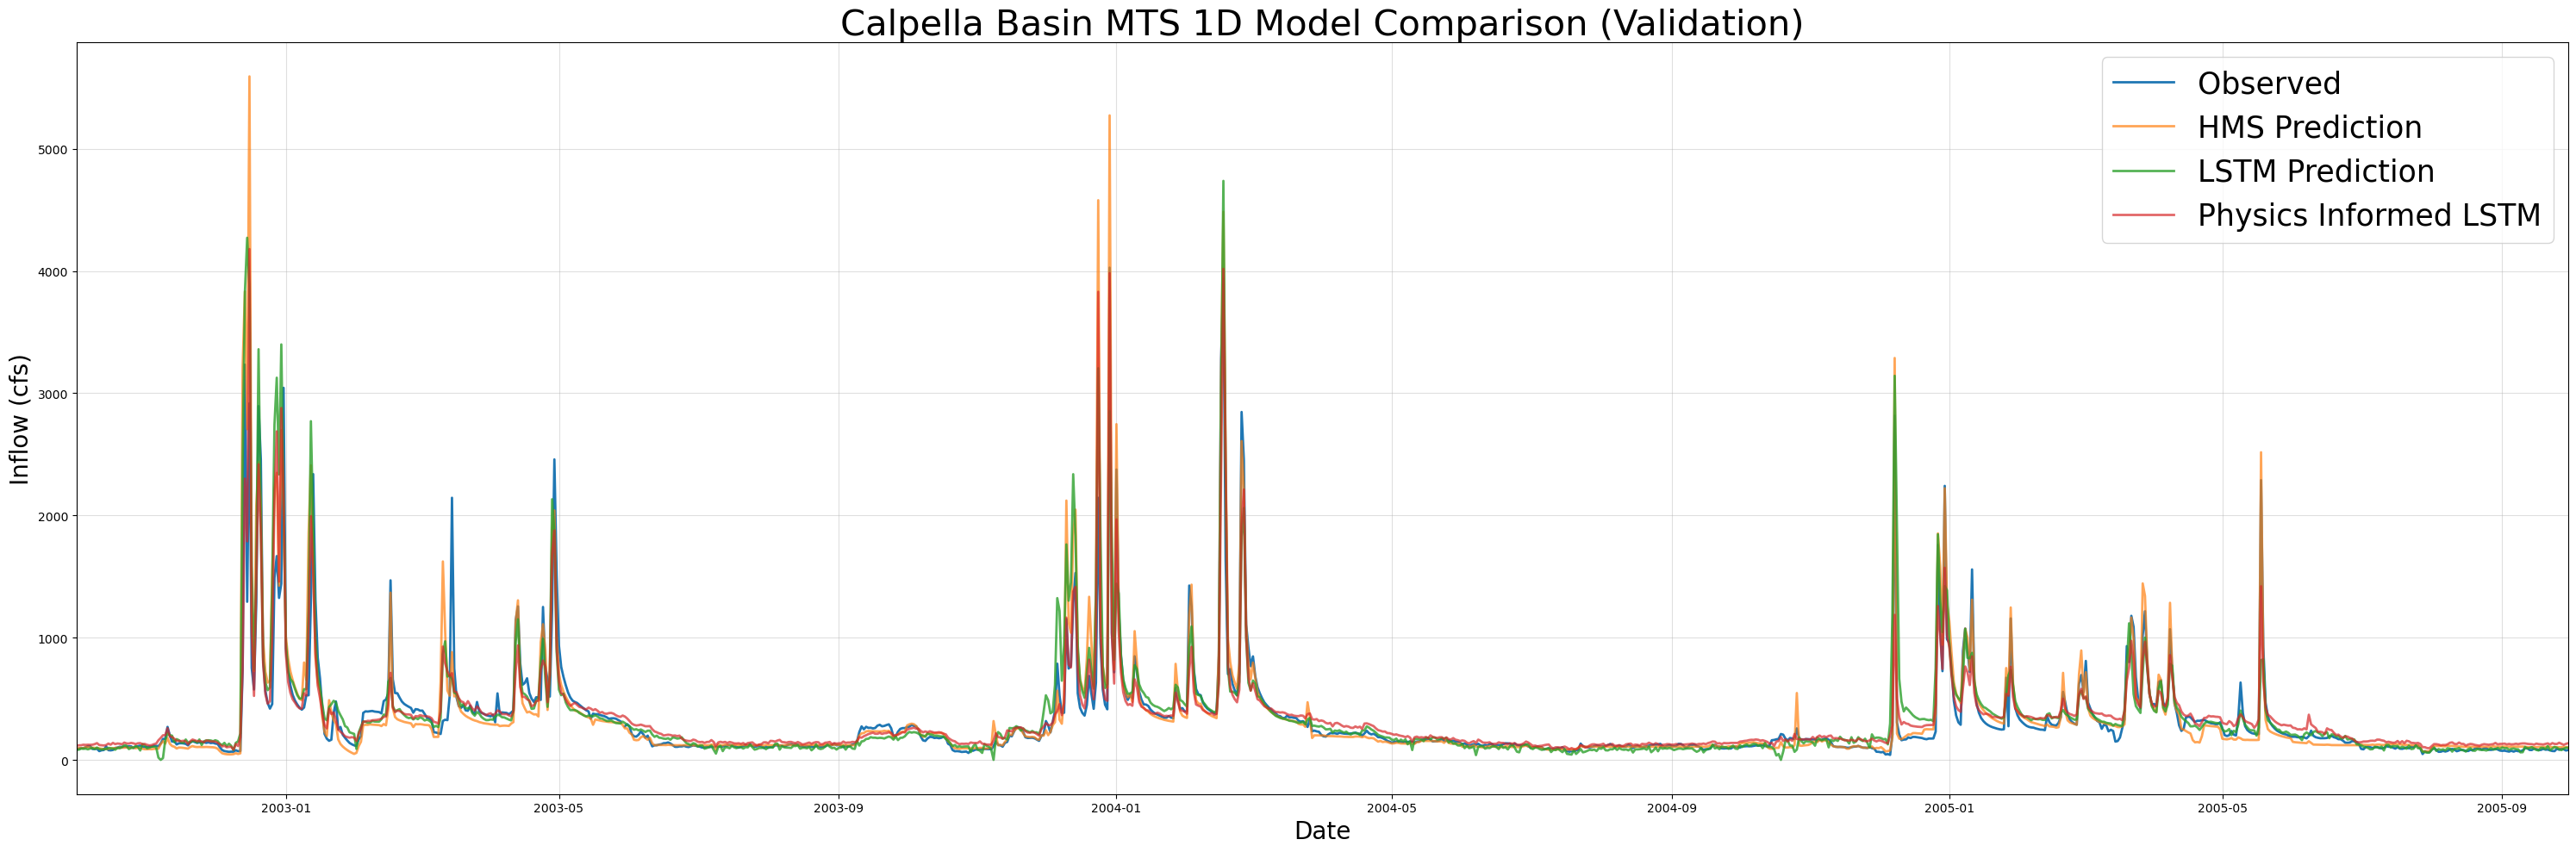

In [16]:
if not skip_best_model_train:
    print("\nPlotting combined MTS results (Validation, 1D)...")
    combinedPlot(
        lstm_results=noPhys_val_csv_1D,
        lstmPhysics_results=phys_val_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Calpella Basin MTS 1D Model Comparison (Validation)",
        fName="calpella_mts_val_metrics_1D.csv",
        plot_filename="calpella_mts_val_1D_comparison.png",
        timeseries_filename="calpella_mts_val_1D_combined_ts.csv"
    )
else:
    combined_df_1D = pd.read_csv("calpella_mts_val_1D_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_1D,
        title="Calpella Basin MTS 1D Model Comparison (Validation)",
        fName="calpella_mts_val_metrics_1D.csv"
    )

In [17]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=noPhys_val_csv_1D,
        lstmPhysics_results=phys_val_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Calpella Basin MTS 1D Model Comparison (Validation)",
        fName="calpella_mts_val_metrics_1D.csv",
        timeseries_filename="calpella_mts_val_1D_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_1D,
        title="Calpella Basin MTS 1D Model Comparison (Validation)",
        fName="calpella_mts_val_metrics_1D.csv"
    )

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: Futu

[INFO] Wrote metrics CSV: calpella_mts_val_metrics_1D.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

[INFO] Wrote metrics CSV: calpella_mts_val_metrics_1H.csv


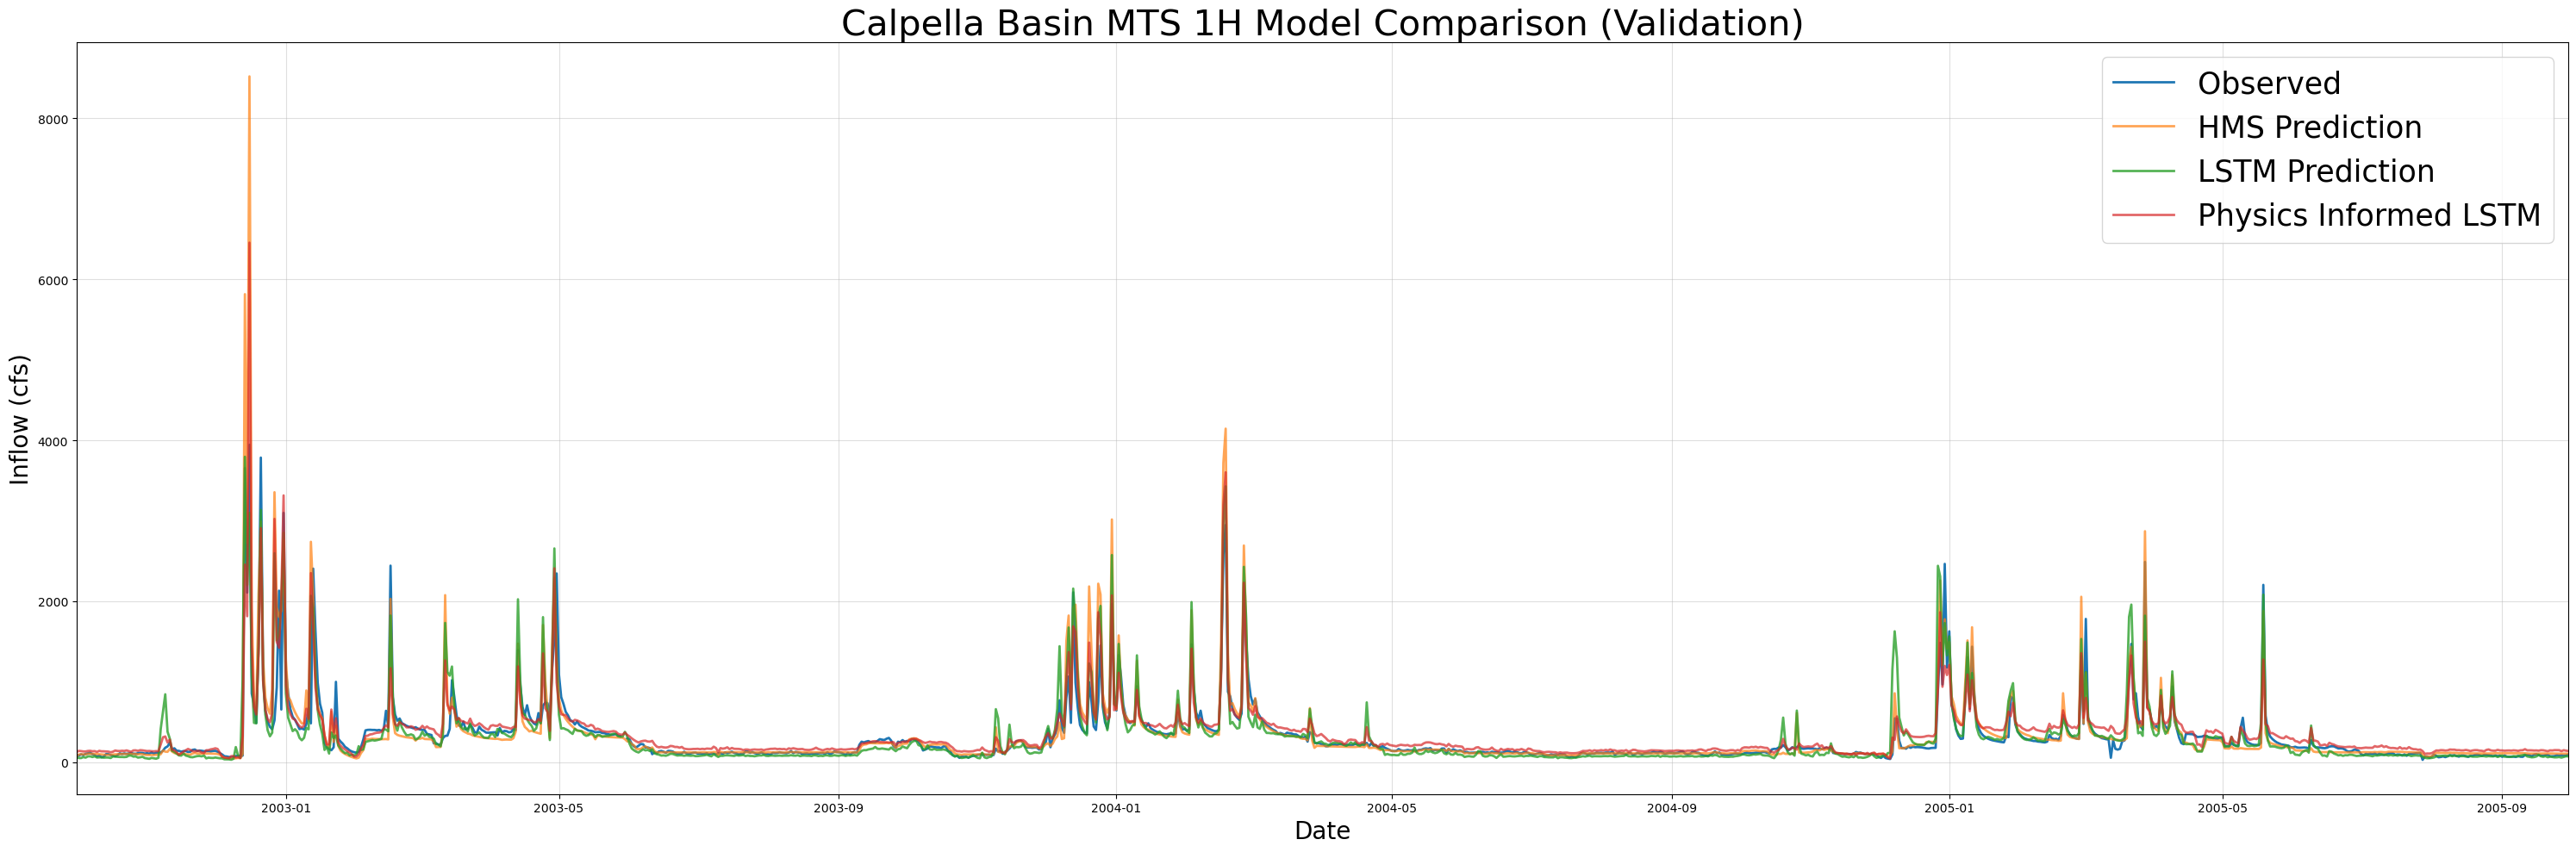

In [18]:
if not skip_best_model_train:
    print("\nPlotting combined MTS results (Validation, 1H)...")
    combinedPlot(
        lstm_results=noPhys_val_csv_1H,
        lstmPhysics_results=phys_val_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Calpella Basin MTS 1H Model Comparison (Validation)",
        fName="calpella_mts_val_metrics_1H.csv",
        plot_filename="calpella_mts_val_1H_comparison.png",
        timeseries_filename="calpella_mts_val_1H_combined_ts.csv"
    )
else:
    combined_df_1H = pd.read_csv("calpella_mts_val_1H_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_1H,
        title="Calpella Basin MTS 1H Model Comparison (Validation)",
        fName="calpella_mts_val_metrics_1H.csv"
    )

In [19]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=noPhys_val_csv_1H,
        lstmPhysics_results=phys_val_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Calpella Basin MTS 1H Model Comparison (Validation)",
        fName="calpella_mts_val_metrics_1H.csv",
        timeseries_filename="calpella_mts_val_1H_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_1H,
        title="Calpella Basin MTS 1H Model Comparison (Validation)",
        fName="calpella_mts_val_metrics_1H.csv"
    )

[INFO] Wrote metrics CSV: calpella_mts_val_metrics_1H.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

In [20]:
if skip_best_model_train:
    val_metrics = pd.read_csv("calpella_mts_val_metrics_1D.csv")
    print(val_metrics)

     Unnamed: 0           HMS          LSTM  Physics_Informed_LSTM
0           NSE      0.743234      0.688513               0.837271
1           MSE  43969.106714  53339.547889           27866.003210
2          RMSE    209.688118    230.953562             166.931133
3           KGE      0.756340      0.800788               0.873346
4     Alpha-NSE      1.224196      1.132421               0.918624
5      Beta-KGE      1.045567      1.075395               1.048218
6      Beta-NSE      0.034868      0.057693               0.036897
7     Pearson-r      0.916154      0.871681               0.915773
8           FHV     18.921339     13.057226              -4.963554
9           FMS     -9.139605      4.344456             -20.015193
10          FLV      5.091743  -2067.015070              47.314309
11  Peak-Timing      0.000000      0.600000               0.000000
12    Peak-MAPE     18.634591     29.529782              29.872920


In [21]:
if skip_best_model_train:
    val_metrics = pd.read_csv("calpella_mts_val_metrics_1H.csv")
    print(val_metrics)

     Unnamed: 0           HMS          LSTM  Physics_Informed_LSTM
0           NSE      0.575793      0.754169               0.738924
1           MSE  64973.357389  37652.485233           39987.615579
2          RMSE    254.898720    194.042483             199.969037
3           KGE      0.632079      0.852193               0.811318
4     Alpha-NSE      1.344511      1.100435               1.010527
5      Beta-KGE      1.063047      0.982543               1.142752
6      Beta-NSE      0.049412     -0.013682               0.111881
7     Pearson-r      0.887291      0.892971               0.877070
8           FHV     25.906090      3.023189              -0.644100
9           FMS    -11.213633     23.153706             -15.226899
10          FLV     34.494237     30.180066               6.935017
11  Peak-Timing      0.250000      0.250000               0.250000
12    Peak-MAPE     54.362808     28.380687              45.903531


# Test Period

In [22]:
if not skip_best_model_train:
    print("\nTraining No-Physics MTS model for test period...")
    mtsNoPhysicsTest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=True,
        extend_train_period=True,
        gpu=-1,
        is_mts=True,
        is_mts_data = True,
    )
    mtsNoPhysicsTest.train()
    no_physics_test_csv_1D, no_physics_test_metrics_1D = mtsNoPhysicsTest.results(period="test", mts_trk="1D")
    no_physics_test_csv_1H, no_physics_test_metrics_1H = mtsNoPhysicsTest.results(period="test", mts_trk="1H")
    print("\n[No-Physics Test] NSE @1D =", no_physics_test_metrics_1D.get("NSE", None))
    print("[No-Physics Test] NSE @1H =", no_physics_test_metrics_1H.get("NSE", None))

In [23]:
if not skip_best_model_train:
    print("\nTraining Physics MTS model for test period...")
    mtsPhysicsTest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file="_",
        hourly=True,
        extend_train_period=True,
        gpu=-1,
        is_mts=True,
        is_mts_data = True,
        basin="Calpella"
    )
    mtsPhysicsTest.train()
    physics_test_csv_1D, physics_test_metrics_1D = mtsPhysicsTest.results(period="test", mts_trk="1D")
    physics_test_csv_1H, physics_test_metrics_1H = mtsPhysicsTest.results(period="test", mts_trk="1H")
    print("\n[Physics Test] NSE @1D =", physics_test_metrics_1D.get("NSE", None))
    print("[Physics Test] NSE @1H =", physics_test_metrics_1H.get("NSE", None))

[INFO] Wrote metrics CSV: calpella_mts_test_metrics_1D.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

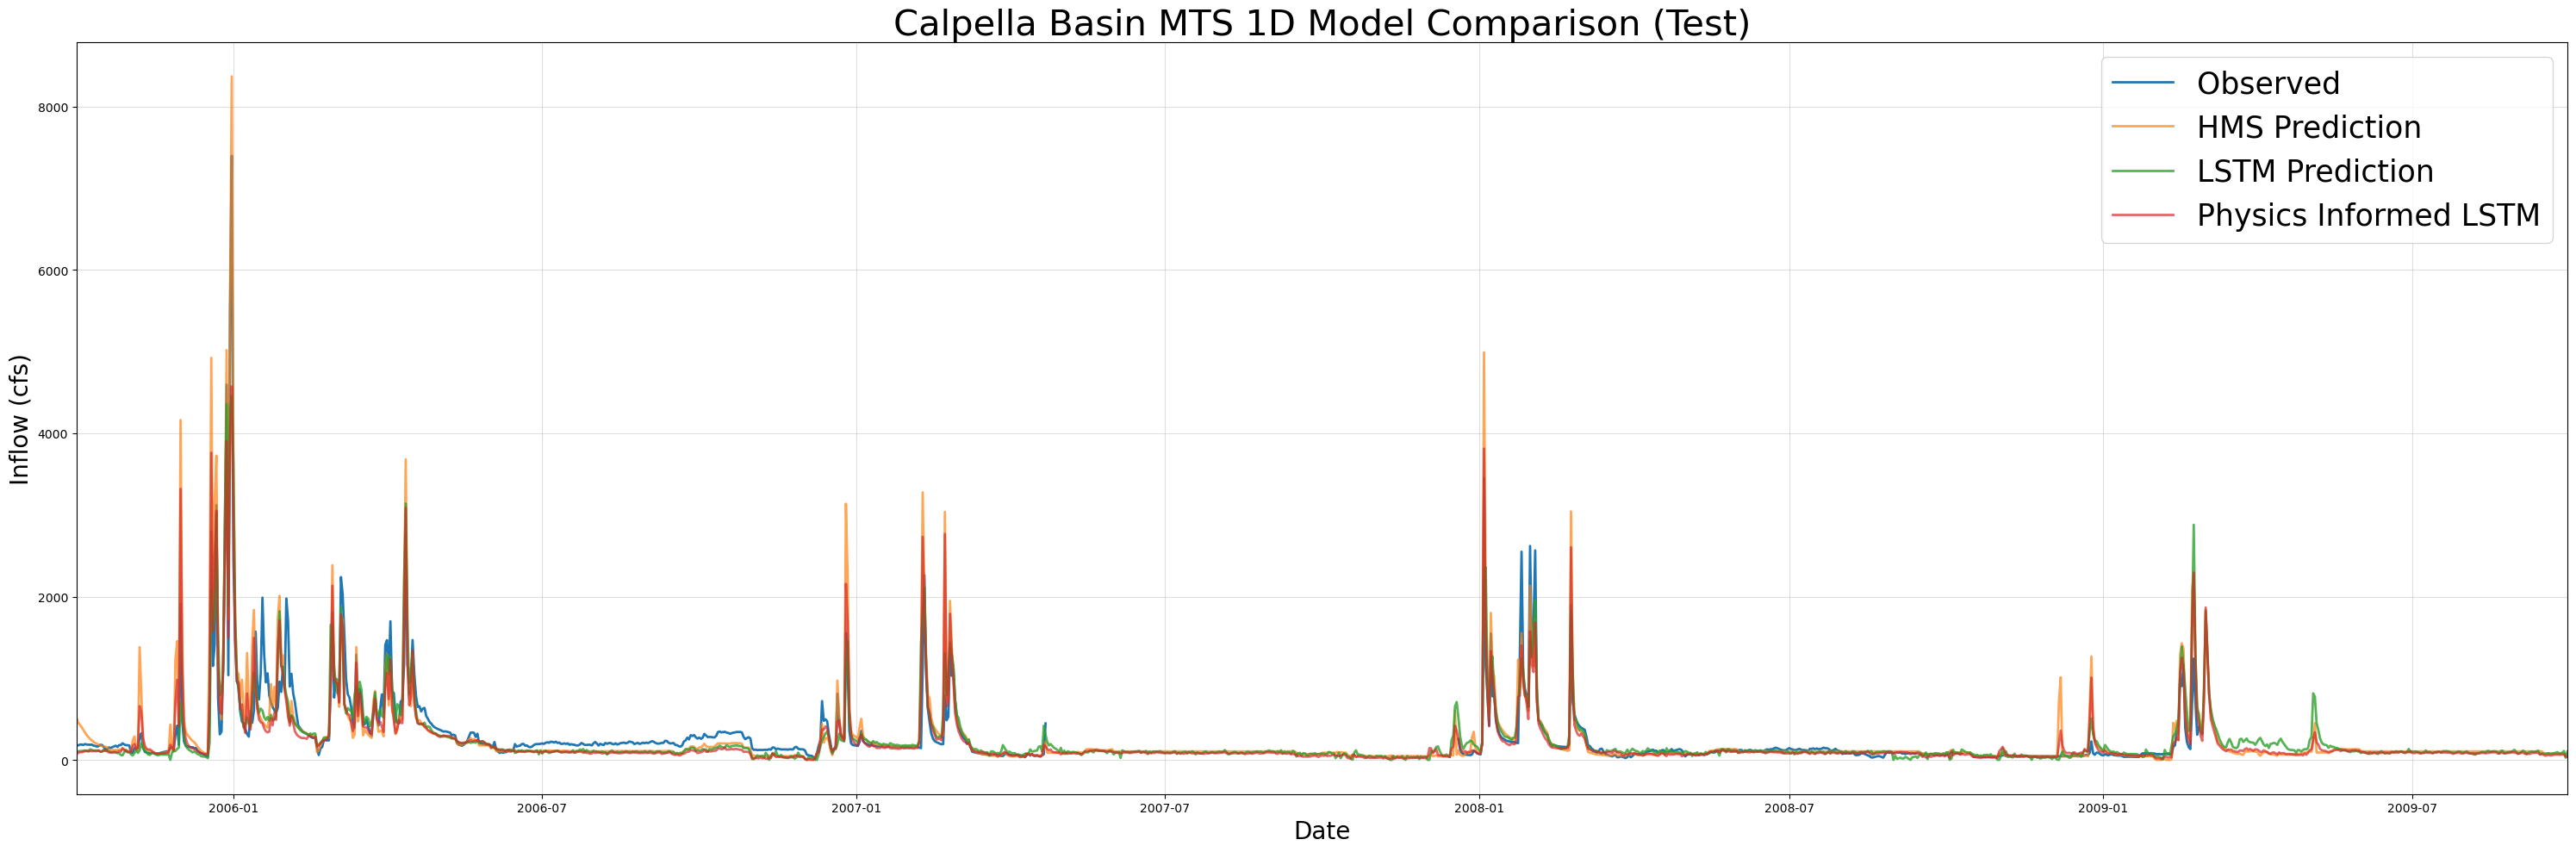

In [24]:
if not skip_best_model_train:
    print("\nPlotting combined MTS results (Test, 1D)...")
    combinedPlot(
        lstm_results=no_physics_test_csv_1D,
        lstmPhysics_results=physics_test_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Calpella Basin MTS 1D Model Comparison (Test)",
        fName="calpella_mts_test_metrics_1D.csv",
        plot_filename="calpella_mts_test_1D_comparison.png",
        timeseries_filename="calpella_mts_test_1D_combined_ts.csv"
    )
else:
    combined_df_test_1D = pd.read_csv("calpella_mts_test_1D_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_test_1D,
        title="Calpella Basin MTS 1D Model Comparison (Test)",
        fName="calpella_mts_test_metrics_1D.csv"
    )

In [25]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=no_physics_test_csv_1D,
        lstmPhysics_results=physics_test_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Calpella Basin MTS 1D Model Comparison (Test)",
        fName="calpella_mts_test_metrics_1D.csv",
        timeseries_filename="calpella_mts_test_1D_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_test_1D,
        title="Calpella Basin MTS 1D Model Comparison (Test)",
        fName="calpella_mts_test_metrics_1D.csv"
    )

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

[INFO] Wrote metrics CSV: calpella_mts_test_metrics_1D.csv


[INFO] Wrote metrics CSV: calpella_mts_test_metrics_1H.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

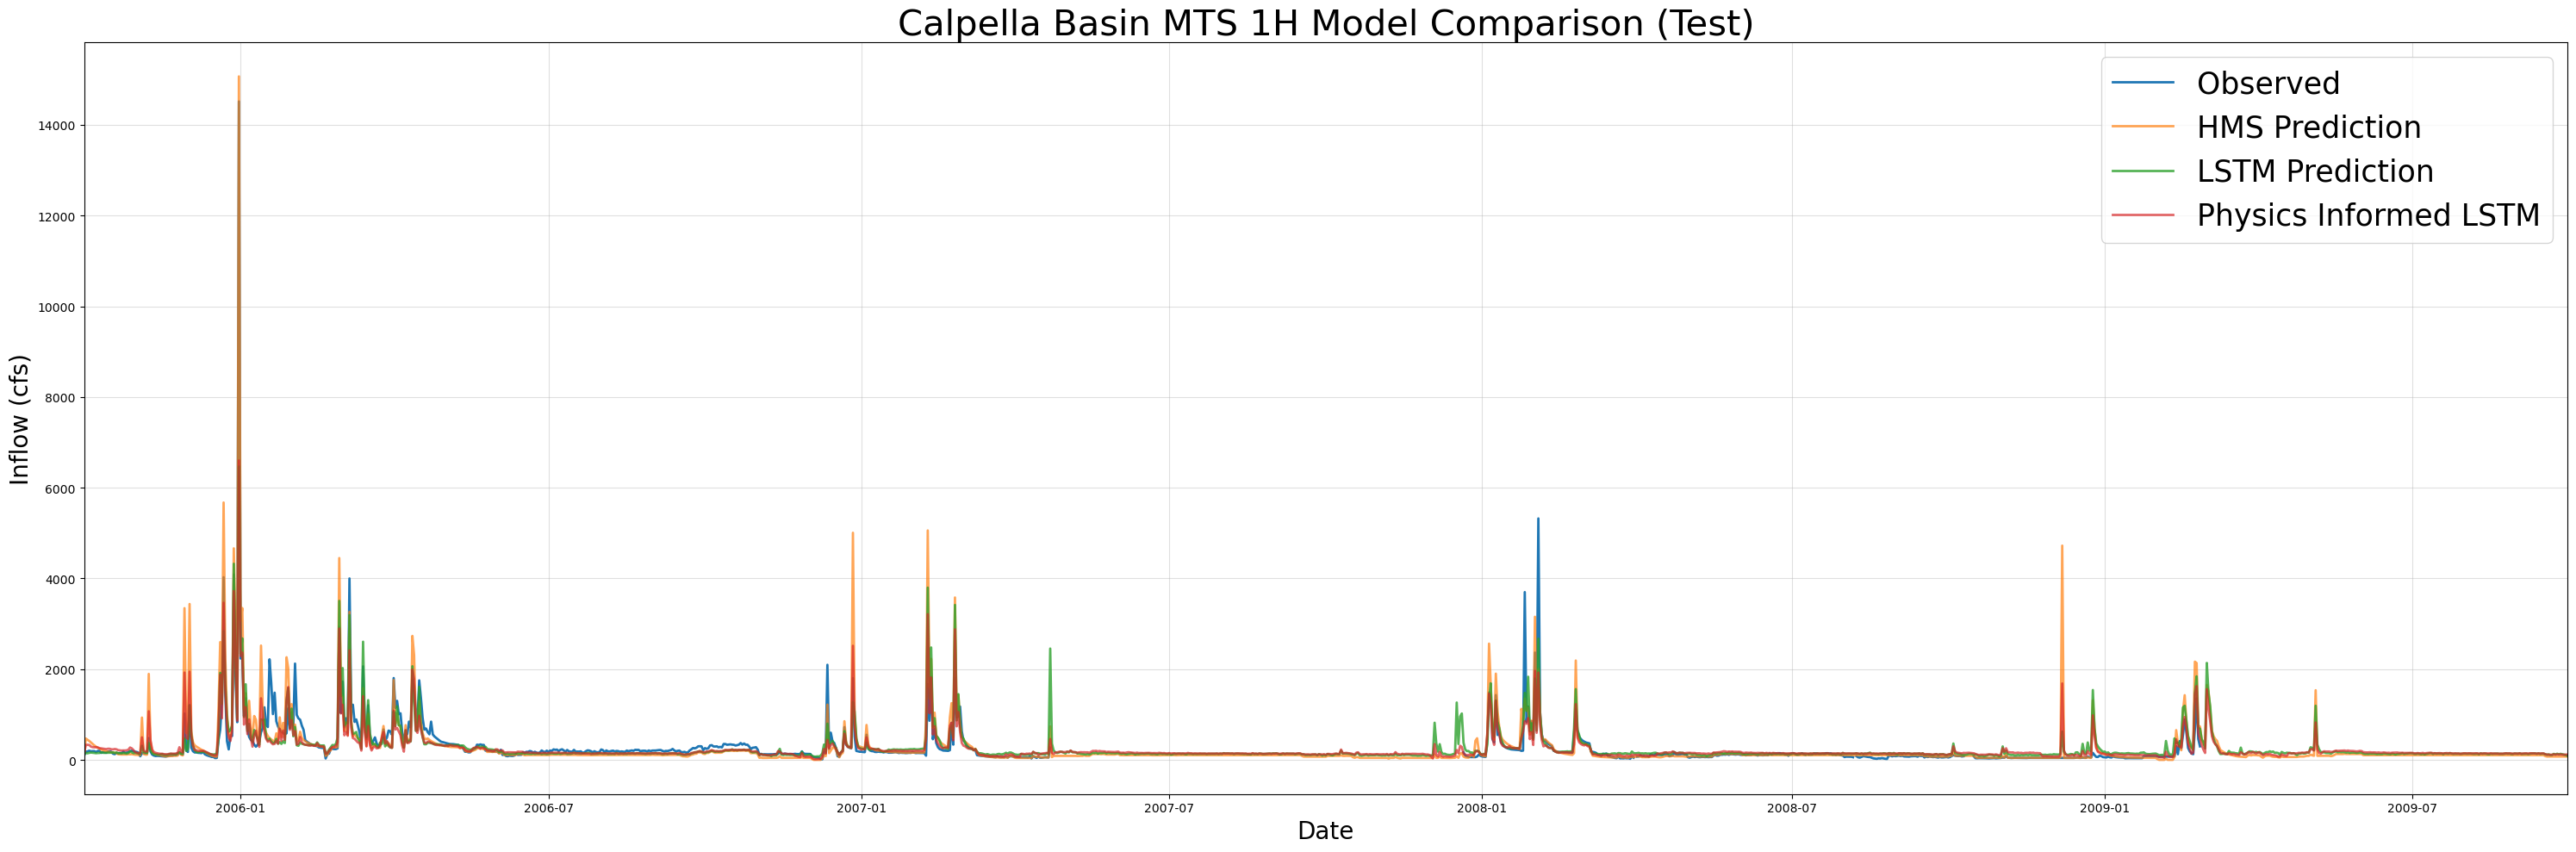

In [26]:
if not skip_best_model_train:
    print("\nPlotting combined MTS results (Test, 1H)...")
    combinedPlot(
        lstm_results=no_physics_test_csv_1H,
        lstmPhysics_results=physics_test_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Calpella Basin MTS 1H Model Comparison (Test)",
        fName="calpella_mts_test_metrics_1H.csv",
        plot_filename="calpella_mts_test_1H_comparison.png",
        timeseries_filename="calpella_mts_test_1H_combined_ts.csv"
    )
else:
    combined_df_test_1H = pd.read_csv("calpella_mts_test_1H_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_test_1H,
        title="Calpella Basin MTS 1H Model Comparison (Test)",
        fName="calpella_mts_test_metrics_1H.csv"
    )

In [27]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=no_physics_test_csv_1H,
        lstmPhysics_results=physics_test_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Calpella Basin MTS 1H Model Comparison (Test)",
        fName="calpella_mts_test_metrics_1H.csv",
        timeseries_filename="calpella_mts_test_1H_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_test_1H,
        title="Calpella Basin MTS 1H Model Comparison (Test)",
        fName="calpella_mts_test_metrics_1H.csv"
    )

[INFO] Wrote metrics CSV: calpella_mts_test_metrics_1H.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/calpella_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB

In [28]:
if skip_best_model_train:
    test_metrics = pd.read_csv("calpella_mts_test_metrics_1D.csv")
    print(test_metrics)

     Unnamed: 0           HMS          LSTM  Physics_Informed_LSTM
0           NSE      0.703597      0.803526               0.789985
1           MSE  75702.868644  50180.541828           53638.922920
2          RMSE    275.141543    224.010138             231.600784
3           KGE      0.748740      0.849556               0.837311
4     Alpha-NSE      1.222459      0.911226               0.943357
5      Beta-KGE      1.059538      0.935134               0.891795
6      Beta-NSE      0.034933     -0.038059              -0.063487
7     Pearson-r      0.899508      0.897311               0.892524
8           FHV     25.602362    -10.240734              -2.277472
9           FMS     -0.149804     -5.901159              -2.481232
10          FLV   -969.620583   -940.359451            -970.888263
11  Peak-Timing      0.000000      0.400000               0.000000
12    Peak-MAPE     55.255902     50.394661              36.858227


In [29]:
if skip_best_model_train:
    test_metrics = pd.read_csv("calpella_mts_test_metrics_1H.csv")
    print(test_metrics)

     Unnamed: 0            HMS           LSTM  Physics_Informed_LSTM
0           NSE       0.668932       0.689790               0.687385
1           MSE  133578.697457  125162.835633          126133.336036
2          RMSE     365.484196     353.783600             355.152553
3           KGE       0.773225       0.680899               0.625627
4     Alpha-NSE       1.170422       0.726147               0.658835
5      Beta-KGE       1.076653       1.025085               0.959172
6      Beta-NSE       0.035578       0.011643              -0.018950
7     Pearson-r       0.871517       0.838133               0.851357
8           FHV      28.558751     -13.165938             -20.605620
9           FMS       1.655551     -31.225329             -39.284611
10          FLV    -977.250642      68.885864             -25.288919
11  Peak-Timing       0.000000       0.000000               0.000000
12    Peak-MAPE      44.087769      43.985651              46.032078
